In [30]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from misc import *
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# データ作成（サンプルデータ）
df = pd.read_csv('SPY_VIX.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df = df.rename(columns = {'SPY_Close':'SPY', "VIX_Close":'VIX'})
df['VIX'] = df['VIX'] / 100

df_options = pd.DataFrame(index=df.index)
all_moneyness = np.linspace(90, 105, 16).astype(int)
for mny in all_moneyness:
    df_options[mny] = df['VIX'] * ((1.05 - mny/100)**2 + 1) 
df["rf"] = 0.01

# 第三金曜日（ないなら翌営業日）
df_backtest = df.loc[get_third_fridays(df)]
df_backtest['Return'] = df_backtest['SPY'].pct_change()
df_backtest.dropna(inplace=True)


# バックテスト
wealth_list = list()
result_list = list()

for date in df_backtest.index:
    # 市場の状態
    idx_date = df_options.index.get_loc(date)
    last_date = df_options.index[idx_date-1]
    S = df_backtest.loc[date, 'SPY']
    r = df_backtest.loc[date,'rf']
    T = 1/12
    
    # ペイオフ計算
    if date != df_backtest.index[0]:
        payoff_all = -np.maximum(S_last * K_short / 100 - S, 0) + np.maximum(S_last * K_long / 100 - S, 0) + payoff_premium# payoff premiumは前月時点で確定
        wealth_list.append(payoff_all / S_last)
    else:
        wealth_list.append(0)
        

    # 意思決定
    ## 前日終値（IV）で意思決定: どの行使価格のオプションを取引するか決定
    ## 翌日終値でポジション建て: 実際のプレミアムは翌日のIVで計算
    premium_matrix, strikes_pshort, strikes_plong = calculate_premium_matrix_with_iv(S, T, r, df_options, last_date) # PUT Short Premium - PUT Long Premium
    delta_short_matrix, strikes_pshort, strikes_plong = calculate_delta_matrix_with_iv(S, T, r, df_options, last_date)
    prob_pshort_matrix = 1 - np.abs(delta_short_matrix)
    weighted_return_matrix = (premium_matrix / S) * prob_pshort_matrix
    optimal_result = find_optimal_strikes(weighted_return_matrix, strikes_pshort, strikes_plong)
    result_list.append(optimal_result)

    # 価格計算
    K_short = optimal_result["optimal_k_short"]
    K_long = optimal_result["optimal_k_long"]
    pshort = PutOptionPricer(S, S * K_short / 100, T, r, df_options.loc[date, K_short]) 
    plong = PutOptionPricer(S, S * K_long / 100, T, r, df_options.loc[date, K_long])
    payoff_premium = pshort.premium() - plong.premium()
    S_last = S


# 結果集計
df_result = pd.DataFrame(index = df_backtest.index)
df_result['SPY'] = df_backtest['Return'].values
df_result.iloc[0,0] = 0
df_result['strategy'] = wealth_list

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Sharpe Ratio,CVaR (5%),Mean Return (Monthly),Volatility (Monthly),Alpha (Monthly),Beta,Correlation
Strategy,1.2287,-0.0801,0.0117,0.0330,0.006,0.6026,0.9148
SPY,0.6576,-0.1222,0.0095,0.0501,NaN,1.0000,1.0000


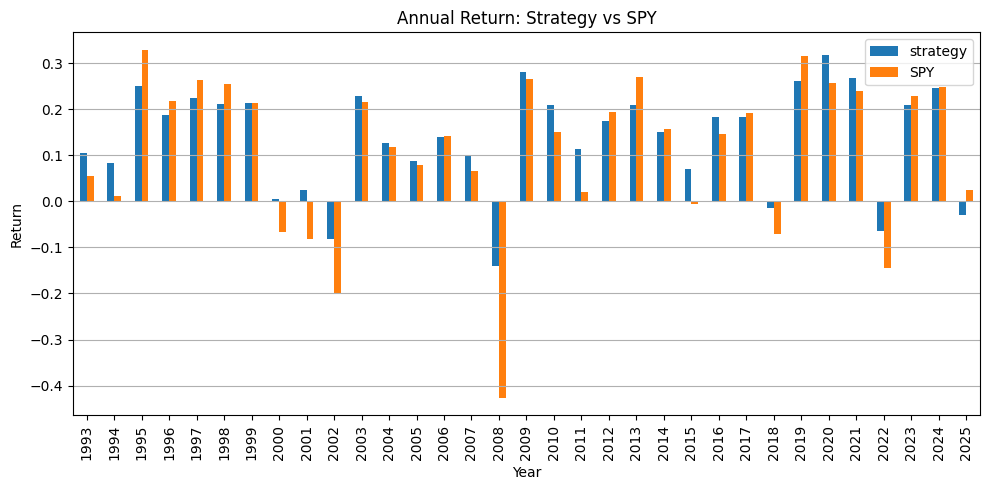

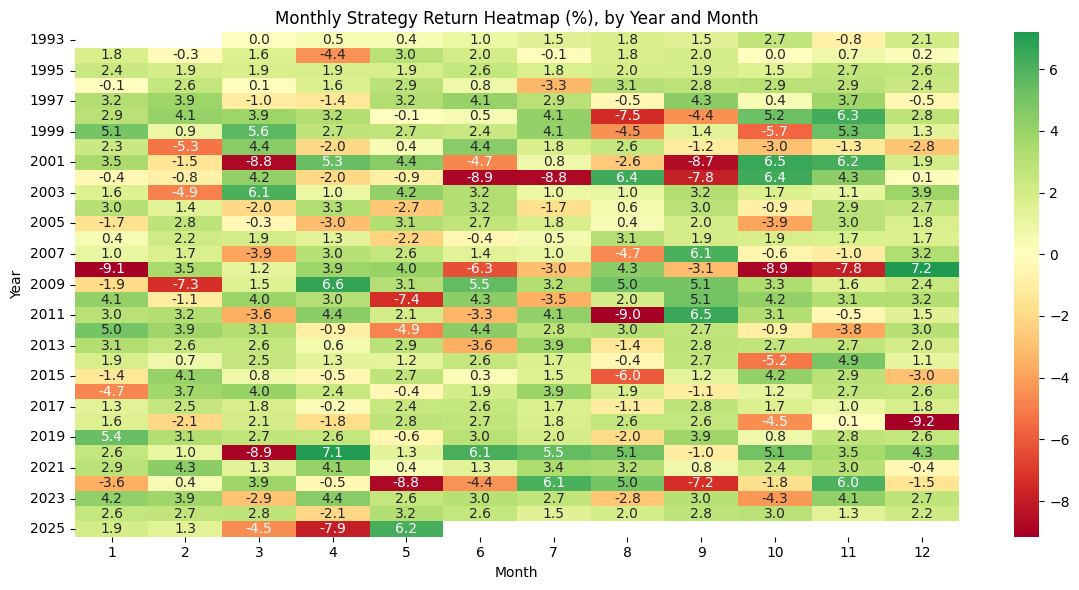

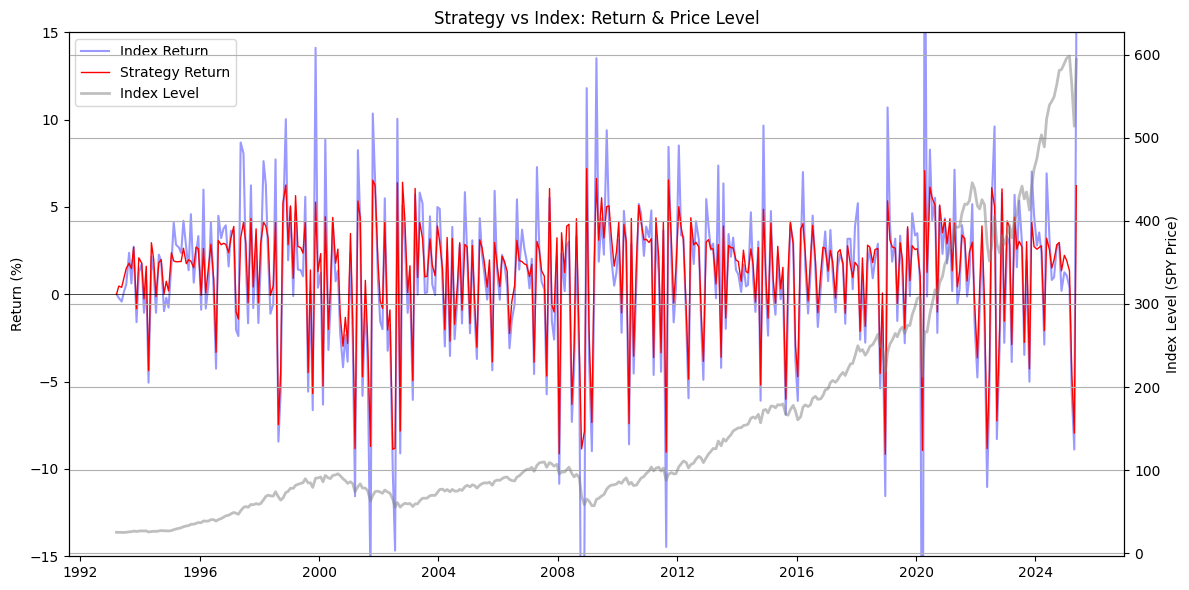

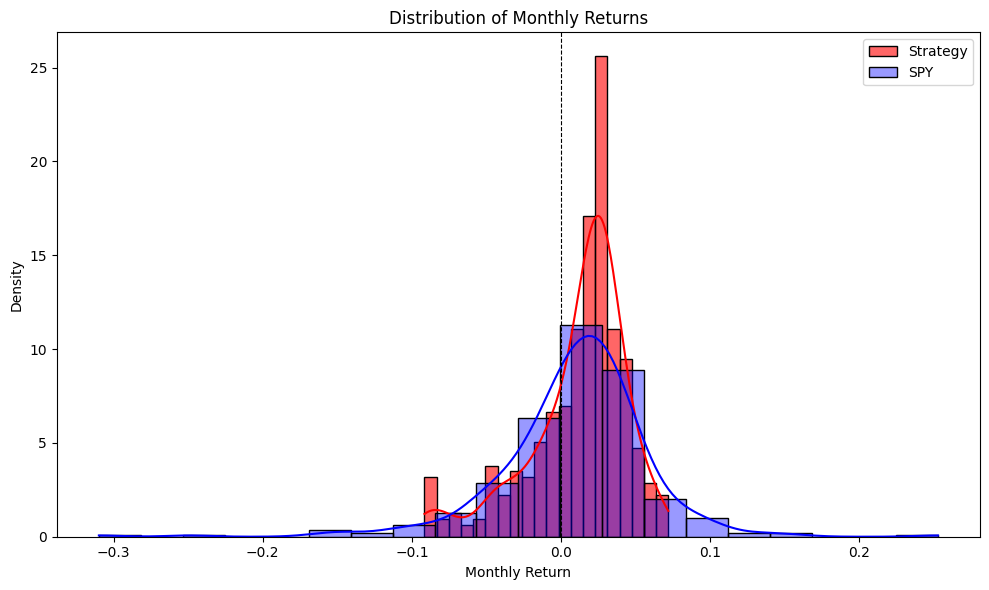

In [33]:
# コピーして安全に処理
df_eval = df_result.copy()
df_eval['Year'] = df_eval.index.year
df_eval['Month'] = df_eval.index.month
df_eval['YearMonth'] = df_eval.index.to_period('M')

# --- 指標関数 ---
def sharpe_ratio(returns, risk_free_rate=0.0, annualize=True, freq=12):
    excess = returns - risk_free_rate
    mean = excess.mean()
    std = excess.std()
    sharpe = mean / std if std != 0 else np.nan
    return sharpe * np.sqrt(freq) if annualize else sharpe

def cvar(returns, alpha=0.05):
    var = np.percentile(returns, alpha * 100)
    return returns[returns <= var].mean()

def beta_alpha(strategy, benchmark):
    X = sm.add_constant(benchmark)
    model = sm.OLS(strategy, X).fit()
    alpha = model.params['const']
    beta = model.params[benchmark.name]
    return alpha, beta

# --- パフォーマンス要約 ---
performance_data = {
    "Sharpe Ratio": [
        sharpe_ratio(df_eval['strategy']),
        sharpe_ratio(df_eval['SPY'])
    ],
    "CVaR (5%)": [
        cvar(df_eval['strategy']),
        cvar(df_eval['SPY'])
    ],
    "Mean Return (Monthly)": [
        df_eval['strategy'].mean(),
        df_eval['SPY'].mean()
    ],
    "Volatility (Monthly)": [
        df_eval['strategy'].std(),
        df_eval['SPY'].std()
    ],
    "Alpha (Monthly)": [
        beta_alpha(df_eval['strategy'], df_eval['SPY'])[0],
        np.nan
    ],
    "Beta": [
        beta_alpha(df_eval['strategy'], df_eval['SPY'])[1],
        1.0
    ],
    "Correlation": [
        df_eval['strategy'].corr(df_eval['SPY']),
        1.0
    ]
}

df_performance = pd.DataFrame(performance_data, index=["Strategy", "SPY"])
display(df_performance.round(4))

# --- 年次リターン（棒グラフ） ---
df_ret_year = df_eval.groupby('Year')[['strategy', 'SPY']].sum()

plt.figure(figsize=(10, 5))
df_ret_year.plot(kind='bar', ax=plt.gca())
plt.title('Annual Return: Strategy vs SPY')
plt.ylabel('Return')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# --- ヒートマップ（年×月） ---
heatmap_data = df_eval.pivot_table(values='strategy', index='Year', columns='Month', aggfunc='sum') * 100

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='RdYlGn', center=0)
plt.title('Monthly Strategy Return Heatmap (%), by Year and Month')
plt.ylabel('Year')
plt.xlabel('Month')
plt.tight_layout()
plt.show()

# --- 2軸グラフ（SPY水準＋リターン） ---
spy_returns = df_result['SPY']
strategy_returns = df_result['strategy']
spy_levels = df_backtest['SPY']

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_ylabel('Return (%)')
ax1.plot(spy_returns.index, spy_returns * 100, color='blue', label='Index Return', alpha=0.4)
ax1.plot(strategy_returns.index, strategy_returns * 100, color='red', label='Strategy Return', linewidth=1)
ax1.axhline(0, color='black', linewidth=0.5)
ax1.set_ylim(-15, 15)

ax2 = ax1.twinx()
ax2.set_ylabel('Index Level (SPY Price)')
ax2.plot(spy_levels.index, spy_levels, color='gray', label='Index Level', linewidth=2, alpha=0.5)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Strategy vs Index: Return & Price Level')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- リターン分布（ヒストグラム＋KDE） ---
plt.figure(figsize=(10, 6))
sns.histplot(df_result['strategy'], bins=20, color='red', label='Strategy', kde=True, stat='density', alpha=0.6)
sns.histplot(df_result['SPY'], bins=20, color='blue', label='SPY', kde=True, stat='density', alpha=0.4)

plt.title('Distribution of Monthly Returns')
plt.xlabel('Monthly Return')
plt.ylabel('Density')
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# date = datetime.datetime(1993,2,11)
# T = 1/12
# r = df.loc[date,'rf']
# S = df.loc[date,'SPY']

# premium_matrix, strikes_pshort, strikes_plong = calculate_premium_matrix_with_iv(S, T, r, df_options, date) # PUT Short Premium - PUT Long Premium
# print("Matrix of PUT Short Premium - PUT Long Premium")
# display(pd.DataFrame(premium_matrix, index=strikes_pshort, columns=strikes_plong))

# delta_short_matrix, strikes_pshort, strikes_plong = calculate_delta_matrix_with_iv(S, T, r, df_options, date)
# prob_pshort_matrix = 1 - np.abs(delta_short_matrix)

# print("Matrix of Prob of Getting PUT Shorting Premium")
# display(pd.DataFrame(prob_pshort_matrix, index=strikes_pshort, columns=strikes_plong))

# weighted_return_matrix = (premium_matrix / S) * prob_pshort_matrix
# print("Expected Return of Getting Payoff of PUT Short Premium - PUT Long Premium")
# display(pd.DataFrame(weighted_return_matrix, index=strikes_pshort, columns=strikes_plong))

# optimal_result = find_optimal_strikes(weighted_return_matrix, strikes_pshort, strikes_plong)
# print(optimal_result)